In [2]:
import numpy as np
import pandas as pd
import sqlite3 as sql
import requests
import os
import shutil
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
def download_file():
    global dump
    url = "https://github.com/lerocha/chinook-database/raw/master/ChinookDatabase/DataSources/Chinook_Sqlite.sqlite"
    dump = requests.get(url, stream=True).raw

'''
Used to save the downloaded Chinook Database into an sqlite database file.
'''
def save_file():
    global dump
    location = os.path.relpath("exampledb.sqlite")
    with open("exampledb.sqlite", 'wb') as location:
        shutil.copyfileobj(dump, location)
    del dump
"""
This code snippet downloads the Chinook database, connects to it, and prepares for queries to be executed.
"""
# Grabbing copy of databaseR
download_file()
# Saving copy of database to a local file
save_file()
# Create a connection object that represents a database    
conn = sql.connect("exampledb.sqlite")
# Once the connection to the database is opened, we create a Cursor object to execute queries
c = conn.cursor()

In [4]:
q3= c.execute('''/*  Want to look at 4 things:
                        1. Total number of customers, 
                        2. Total value of sales
                        3. Average value of sales per cusomer
                        4. Average order value
                     Across all countries in the database*/
WITH countries_renamed AS (
SELECT
    i.CustomerId,
    i.total price_per_item,
    i.InvoiceId invoices,
    CASE --Countries with only one sale gets placed in other
        WHEN (SELECT COUNT(*)
              FROM Customer
              WHERE country = c.country) = 1 THEN "Other"
        ELSE c.country
    END
    AS country
FROM Invoice i
INNER JOIN customer c ON c.CustomerId  = i.CustomerId
)

SELECT /* Create variables to determine business stats*/
country,
total_customers,
total_sales,
sales_per_cust,
sales_per_purchase
FROM
(
SELECT 
country,
COUNT(DISTINCT cr.CustomerId) total_customers, -- calculates total customers
ROUND(SUM(price_per_item),2) total_sales, -- calculates total sales
ROUND(SUM(price_per_item) / COUNT(DISTINCT CustomerId),2) sales_per_cust, -- finds sales per customer
ROUND(SUM(price_per_item) / COUNT(DISTINCT invoices),2) sales_per_purchase, --finds sales per purchase
CASE
    WHEN cr.country = "Other" THEN 1 --To ensure Other label is at bottom of table
    ELSE 0
    END
    AS sort_index
FROM countries_renamed cr
GROUP BY country
ORDER BY sort_index ASC, total_sales DESC); --sort by ascending index, descending sales''')
df = pd.DataFrame(c.fetchall())

In [5]:
df.rename(columns={0:'Country', 1:'Total Customers', 2:'total_sales', 3:'sales_per_cust', \
                   4:'sales_per_purchase'}, inplace=True)
df.set_index('Country', inplace=True)
df.head()

,Total Customers,total_sales,sales_per_cust,sales_per_purchase
Country,,,,
USA,13,523.06,40.24,5.75
Canada,8,303.96,37.99,5.43
France,5,195.10,39.02,5.57
Brazil,5,190.10,38.02,5.43
Germany,4,156.48,39.12,5.59


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

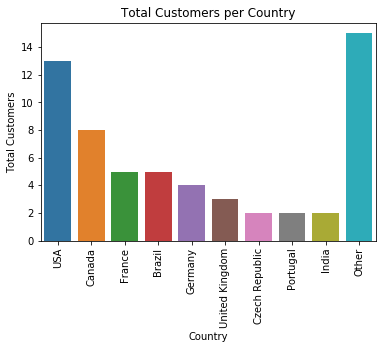

In [6]:
sns.barplot(x=df.index, y='Total Customers', data=df).set_title('Total Customers per Country')
plt.xticks(rotation=90)

In [7]:
df['Customer Sales %'] = round((df['total_sales']/sum(df['total_sales']))*100,2)
df.head()

,Total Customers,total_sales,sales_per_cust,sales_per_purchase,Customer Sales %
Country,,,,,
USA,13,523.06,40.24,5.75,22.46
Canada,8,303.96,37.99,5.43,13.05
France,5,195.10,39.02,5.57,8.38
Brazil,5,190.10,38.02,5.43,8.16
Germany,4,156.48,39.12,5.59,6.72


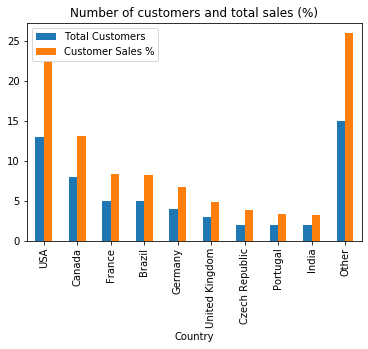

In [8]:
df.plot(y=['Total Customers', 'Customer Sales %'], kind="bar", title='Number of customers and total sales (%)')

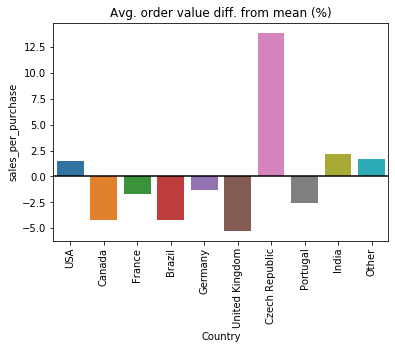

In [9]:
avg_order = df["sales_per_purchase"].copy()
avg_order = ((avg_order - avg_order.mean()) / avg_order.mean())*100
sns.barplot(x=df.index, y=avg_order).set_title("Avg. order value diff. from mean (%)")
plt.xticks(rotation=90)
plt.axhline(0, color='k')